In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.metrics import precision_score, recall_score

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
names = data.class_names

Found 10000 files belonging to 10 classes.


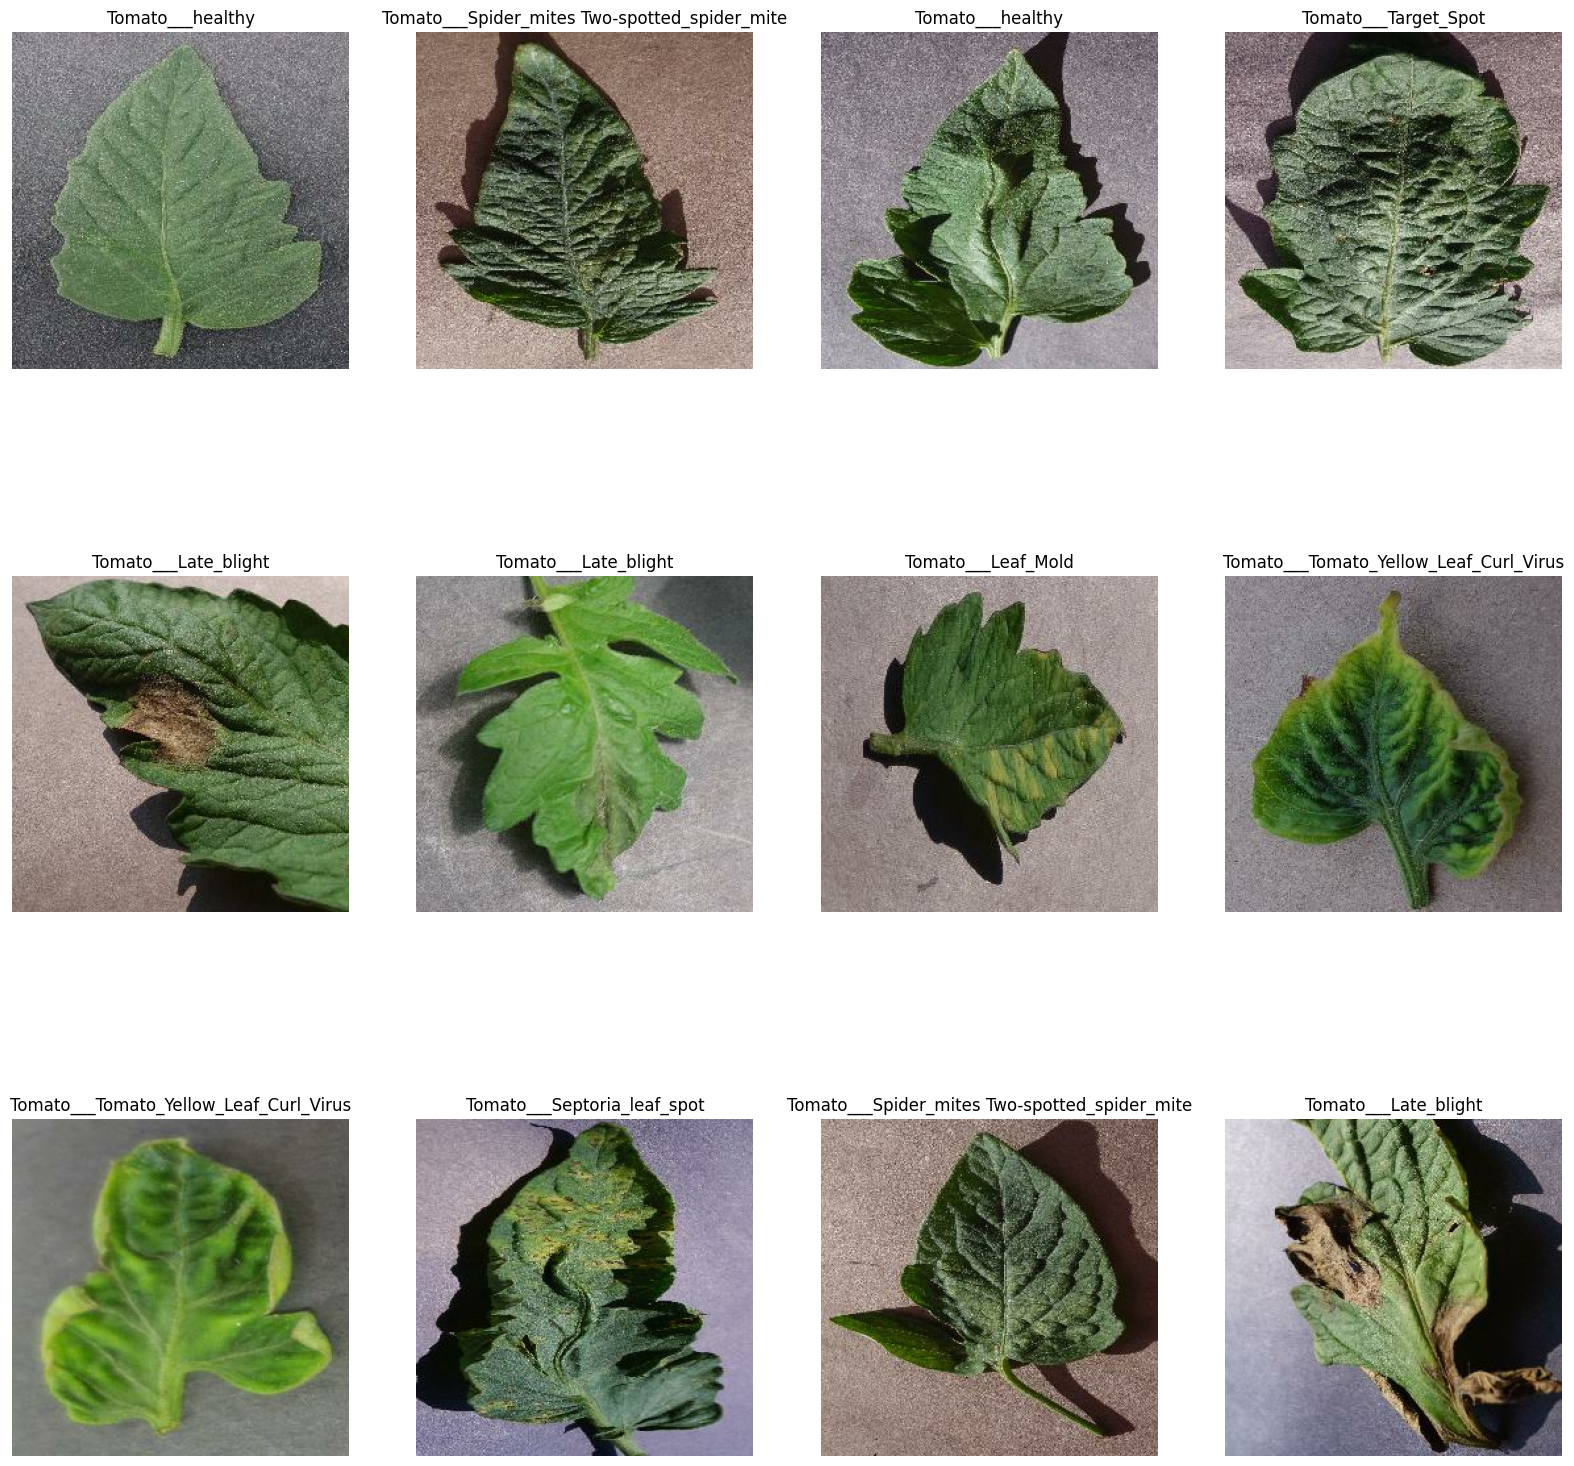

In [4]:
plt.figure(figsize=(20, 20))
for image_batch, label_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(names[label_batch[i]])
        plt.axis("off")
        
    


In [5]:
def train_test_split(ds, train=0.8, val=0.1, test=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train * ds_size)
    val_size = int(val * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [6]:
numb_classes = 10

In [7]:
train_ds, val_ds, test_ds = train_test_split(data)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [10]:
 data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.4),
 ])

In [11]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS) ),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(128, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(128, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(numb_classes, activation='softmax'),
])
model.build(input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
analysis = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
250/250 [==============================] - 438s 2s/step - loss: 2.0389 - accuracy: 0.2216 - val_loss: 1.7706 - val_accuracy: 0.3750
Epoch 2/50
250/250 [==============================] - 375s 1s/step - loss: 1.5023 - accuracy: 0.4446 - val_loss: 1.6073 - val_accuracy: 0.4335
Epoch 3/50
250/250 [==============================] - 353s 1s/step - loss: 1.1487 - accuracy: 0.5859 - val_loss: 1.6175 - val_accuracy: 0.5363
Epoch 4/50
250/250 [==============================] - 353s 1s/step - loss: 0.9461 - accuracy: 0.6581 - val_loss: 1.5640 - val_accuracy: 0.5343
Epoch 5/50
250/250 [==============================] - 353s 1s/step - loss: 0.7792 - accuracy: 0.7199 - val_loss: 2.2819 - val_accuracy: 0.4980
Epoch 6/50
250/250 [==============================] - 365s 1s/step - loss: 0.6638 - accuracy: 0.7599 - val_loss: 1.4016 - val_accuracy: 0.6109
Epoch 7/50
250/250 [==============================] - 384s 2s/step - loss: 0.5975 - accuracy: 0.7839 - val_loss: 1.4748 - val_accuracy: 0.6099

In [15]:
model.evaluate(test_ds)

32/32 [==============================] - 48s 342ms/step - loss: 0.2562 - accuracy: 0.9180


[0.2561595141887665, 0.91796875]

In [18]:

def predict(model, img):
    img_to_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_to_array = tf.expand_dims(img_to_array, 0)
    preed = model.predict(img_to_array)
    pred_class = names[np.argmax(preed[0])]
    conf = round(100 * (np.max(preed[0])), 2)
    return pred_class, conf

1/1 [==============================] - 0s 30ms/step


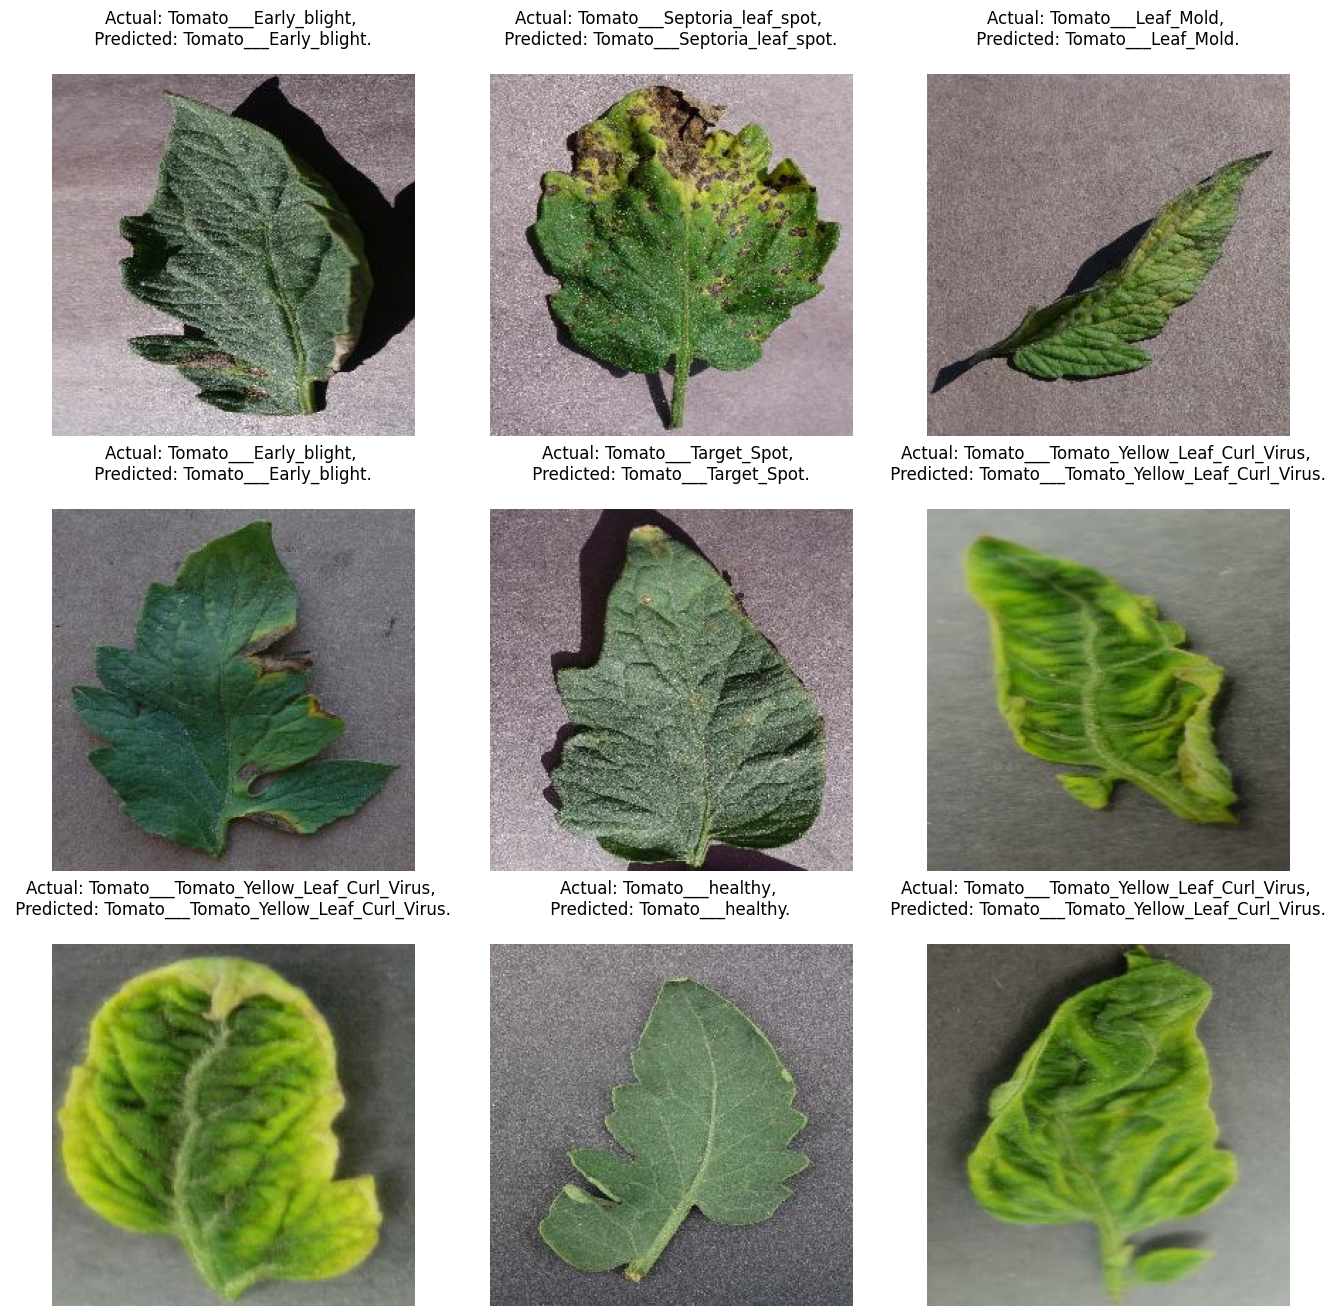

In [19]:
plt.figure(figsize=(16, 16))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n ")
        plt.axis("off")


In [20]:
actuals = []
predictions = []
for images, labels in test_ds.take(1):
    for i in range(len(test_ds)):
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = names[labels[i]]
        predictions.append(predicted_class)
        actuals.append(actual_class)
precision = precision_score(actuals, predictions, average='macro')
recall = recall_score(actuals, predictions, average='macro')   
recall

1/1 [==============================] - 0s 30ms/step


1.0

In [22]:
model_version=3
model.save(f"./algorithm/{model_version}")


INFO:tensorflow:Assets written to: ./algorithm/3\assets


INFO:tensorflow:Assets written to: ./algorithm/3\assets
